In [1]:
from calibration_sql_type_reader import TypeTopLogitFormatSequenceReader

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric import ECEMetric

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


t5-small
type: 1: 13757
type: 2: 20264
type: 3: 2483


/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


t5-base
type: 1: 13757
type: 2: 20264
type: 3: 2483


/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


t5-large
type: 1: 7769
type: 2: 11996
type: 3: 1210


/home/estengel/calibration_metric/calibration_metric/utils/warnings.py:12: RuntimeWarning: Metric Weighted ECE has less than 3 active bins
  warnings.warn(f"Metric {metric_name} has less than 3 active bins", RuntimeWarning)


facebook/bart-base
type: 1: 8294
type: 2: 17951
type: 3: 1943
facebook/bart-large
type: 1: 8294
type: 2: 17951
type: 3: 1943
Salesforce/codet5-base
type: 1: 7042
type: 2: 20147
type: 3: 2384


/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


t5-small-lower
type: 1: 13757
type: 2: 20264
type: 3: 2483


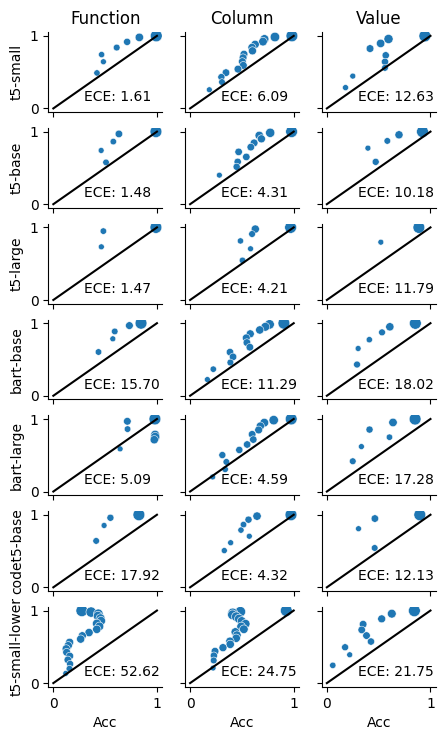

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 

metric = ECEMetric(binning_strategy="adaptive", return_df=True)

spider_paths_and_models = [("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            "t5-small", "t5-small"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            "t5-base", "t5-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits", 
                             "t5-large",  "t5-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-base_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "facebook/bart-base", "facebook/bart-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-large_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "facebook/bart-large", "facebook/bart-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/codet5-base_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits",
                            "Salesforce/codet5-base", "Salesforce/codet5-base"),
                            ("/home/estengel/semantic_parsing_with_constrained_lm/src/semantic_parsing_with_constrained_lm/trained_models/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_lower_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "t5-small", "t5-small-lower")]


ece_df = []

fig, axs = plt.subplots(7, 3, figsize=(5, 8.5), sharex=True, sharey=True)
for i, (path, model, real_model) in enumerate(spider_paths_and_models):

    reader = TypeTopLogitFormatSequenceReader(path,
                                              model_name=model)
    preds_by_type, is_correct_by_type = reader.read()

    is_correct_by_type[0]

    types = ['other', 'Function', 'Column', 'Value']


    metric_value_kws = {"x": 0.3, "y":0.1}
    print(real_model)
    for j, type_idx in enumerate([1, 2, 3]): 

        print(f"type: {type_idx}: {len(preds_by_type[type_idx])}")
        ece, df = metric(preds_by_type[type_idx], is_correct_by_type[type_idx])
        ece *= 100
        model_name = real_model.split("/")[-1]

        ece_df.append({"model": model_name, "type": types[type_idx], "ece": ece})
        if i == 0:
            title = types[type_idx]
        else:
            title = None
        plot_df(df, 
            title=title,
            show_legend=False, 
            metric_value=ece, 
            xlabel="Acc",
            ylabel=model_name,
            ax=axs[i,j],
            metric_value_kwargs=metric_value_kws)



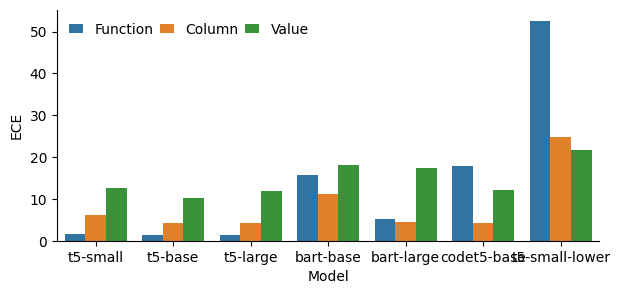

In [8]:
import pandas as pd
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

df = pd.DataFrame(ece_df)
sns.barplot(data=df, x="model", y="ece", hue="type", ax=ax)
ax.set_ylabel("ECE")
ax.set_xlabel("Model")
ax.legend(ncol=3, frameon=False, handlelength=1, columnspacing=0.5) 
sns.despine()